In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gsw
import xarray as xr
import utils
import os
from scipy.spatial import Delaunay
import time as tm
from scipy.sparse import *
from scipy.ndimage.filters import gaussian_filter
from scipy.sparse.linalg import spsolve

def Vhorizontal( r , R , power_shape ):
    
    return power_shape*(r/R)**(power_shape-1)*np.exp( - r**power_shape / R**power_shape )
    
def Vvertical( z , z_eddy , H ):
    
    return np.exp( (z - z_eddy) / H )

#interpolation function



def get_tri_coef(X,Y,newX,newY,verbose=0):

    """
    Inputs:
        origin lon and lat 2d arrays (X,Y)
        child lon and lat 2d arrays (newX,newY)

    Ouputs:
        elem - pointers to 2d gridded data (at lonp,latp locations) from
            which the interpolation is computed (3 for each child point)
        coef - linear interpolation coefficients
    Use:
        To subsequently interpolate data from Fp to Fc, the following
        will work:      Fc  = sum(coef.*Fp(elem),3);  This line  should come in place of all
        griddata calls. Since it avoids repeated triangulations and tsearches (that are done
        with every call to griddata) it should be much faster.
    """
    if len(X.shape)==1:
       Xp = np.array([X, Y]).T
    else: 
       Xp = np.array([X.ravel(), Y.ravel()]).T

    Xc = np.array([newX.ravel(), newY.ravel()]).T

    #Xp = np.array([X.ravel(), Y.ravel()]).T
    Xc = np.array([newX.ravel(), newY.ravel()]).T

    #Compute Delaunay triangulation
    if verbose==1: tstart = tm.time()
    tri = Delaunay(Xp)
    if verbose==1: print ('Delaunay Triangulation', tm.time()-tstart)

    #Compute enclosing simplex and barycentric coordinate (similar to tsearchn in MATLAB)
    npts = Xc.shape[0]
    p = np.zeros((npts,3))

    #points = tri.points[tri.vertices[tri.find_simplex(Xc)]]
    points = tri.points[tri.simplices[tri.find_simplex(Xc)]] #charly fix

#%cpaste
    if verbose==1: tstart = tm.time()
    for i in range(npts):

        if verbose==1: print (np.float(i)/npts)

        if tri.find_simplex(Xc[i])==-1:  #Point outside triangulation
             p[i,:] = p[i,:] * np.nan

        else:

            if verbose==1: tstart = tm.time()
            A = np.append(np.ones((3,1)),points[i] ,axis=1)
            if verbose==1: print ('append A', tm.time()-tstart)

            if verbose==1: tstart = tm.time()
            B = np.append(1., Xc[i])
            if verbose==1: print ('append B', tm.time()-tstart)

            if verbose==1: tstart = tm.time()
            p[i,:] = np.linalg.lstsq(A.T,B.T)[0]
            if verbose==1: print ('solve', tm.time()-tstart)




    if verbose==1: print ('Coef. computation 1', tm.time()-tstart)

    if verbose==1: tstart = tm.time()
    #elem = np.reshape(tri.vertices[tri.find_simplex(Xc)],(newX.shape[0],newY.shape[1],3))
    elem = np.reshape(tri.simplices[tri.find_simplex(Xc)],(newX.shape[0],newY.shape[1],3)) #charly fix
    coef = np.reshape(p,(newX.shape[0],newY.shape[1],3))
    if verbose==1: print ('Coef. computation 2', tm.time()-tstart)

    return [elem,coef]




# solve poisson equation



######################################################  
def poisson_matrix_fast(pm,pn):    
######################################################  

    # elliptic equation matrix:  d_xx + d_yy
    [nx,ny] = pm.shape
    
    ############################

    Dxx = spdiags([-pm[:,int(ny/2)]**2, 2*pm[:,int(ny/2)]**2, -pm[:,int(ny/2)]**2], [-1, 0, 1], nx, nx)
    Dyy = spdiags([-pn[int(nx/2),:]**2, 2*pn[int(nx/2),:]**2, -pn[int(nx/2),:]**2], [-1, 0, 1], ny, ny)
    A = kronsum(Dxx, Dyy)

    return A



def save_parameters_to_txt(filename,
    path_save,
    ngrid_x, ngrid_y, ngrid_z,
    dx, dy, Lx,Ly,Lz,
    refinement, stretching,
    type_eddy,
    power_shape, V0_eddy, R_eddy, H_eddy
):
    with open(path_save+filename, 'w') as f:
        f.write(f"ngrid_x {ngrid_x}\n")
        f.write(f"ngrid_y {ngrid_y}\n")
        f.write(f"ngrid_z {ngrid_z}\n")
        f.write(f"dx {dx}\n")
        f.write(f"dy {dy}\n")
        f.write(f"Lx {Lx}\n")
        f.write(f"Ly {Ly}\n")
        f.write(f"Lz {Lz}\n")
        f.write(f"refinement {refinement}\n")
        f.write(f"stretching {stretching}\n")
        f.write(f"type_eddy {type_eddy}\n")
        f.write(f"power_shape {power_shape}\n")
        f.write(f"V0_eddy {V0_eddy}\n")
        f.write(f"R_eddy {R_eddy}\n")
        f.write(f"H_eddy {H_eddy}\n")

/tmp/ipykernel_15740/1645815931.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


### Parameters to change

In [2]:
path_root='/data/hpcflash/users/josnez/Oceananigans/ICE-EDDY_wJ/V0/'

#*****
run_name='C-0/'
#*****

type_eddy = 1
V0_eddy   = 0.5
R_eddy    = 10e3
H_eddy    = 200



In [3]:

path_save=path_root+'init_cond/'+run_name
try:
    os.mkdir(path_save)
except:
    pass

# Define dimensions of grid.

Lx,Ly=200e3,200e3 #good for eddy size R=10e3

dx=500 #in meters #LR : 2e3
dy=500
ngrid_z = 100

ngrid_x = int(Lx/dx)
ngrid_y = int(Ly/dy)


#Dimensions of box channel
Lx=ngrid_x*dx
Ly=ngrid_y*dy
Lz=4000#m

print(ngrid_x,ngrid_y)

# Array of dims of simulation
# Center points
x=np.linspace(dx/2, Lx-dx/2, ngrid_x)
y=np.linspace(dy/2, Ly-dy/2, ngrid_y)

# Edge grid
xu=np.linspace(0, Lx, ngrid_x + 1)
yv=np.linspace(0, Ly, ngrid_y + 1)

# xx,yy=np.meshgrid(x, y)

#Build initial conditions in edge conditions and then before storing interpolate to the center grid
xx,yy=np.meshgrid(xu, yv)


400 400


# Vortex initialization

### Change parameters in the cell below for exploring parameter space: 

To match high latitude (Radius & F_0), but mostly the rossby number. 

In [4]:
#Vortex parameters

posx_eddy = Lx/2.
posy_eddy = Ly/2.
posz_eddy = 0


power_shape          = 20 #2 is gaussian # larger for steep profiles
## Experiments R_N   = 0.3, 0.2, 0.1


lat=80

def coriolis_frequency(latitude_degrees):
    import math
    omega = 7.2921e-5  # Earth's angular velocity (rad/s)
    phi_rad = math.radians(latitude_degrees)
    f0 = 2 * omega * math.sin(phi_rad)
    return f0

f0=coriolis_frequency(lat);print(f0)

window='yes' #if we apply a window to avoid velocity at the edge of the domain
#it's safer for simulations to say yes, but the velocity profile is then not analytical

0.00014362633231480645


## Depth definition:

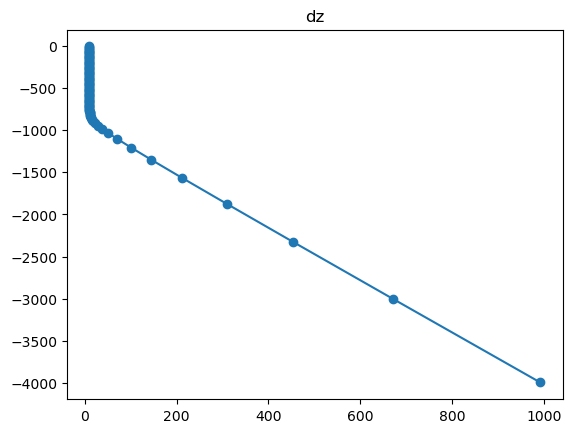

In [5]:
refinement = 4 # controls spacing near surface (higher means finer spaced)
stretching = 40  # controls rate of stretching at bottom

k=np.arange(1,ngrid_z+1)
# Normalized height ranging from 0 to 1
h = (k - 1) / ngrid_z

# Linear near-surface generator
eta = 1 + (h - 1) / refinement

# Bottom-intensified stretching function
Σ = (1 - np.exp(-stretching * h) / (1 - np.exp(-stretching)))

# Generating function
z_faces = Lz * (eta * Σ - 1)

#Flip for consistency with python code
z_faces = np.flipud(-z_faces)

depth = z_faces

plt.title('dz')
plt.plot(np.diff(z_faces),-np.cumsum(np.diff(z_faces)),'o-')
plt.show()

In [6]:
#write in a txt file to save the parameters to put into the julia file
      
save_parameters_to_txt('parameters.txt',
    path_save,
    ngrid_x, ngrid_y, ngrid_z,
    dx, dy, Lx,Ly,Lz,
    refinement, stretching,
    type_eddy,
    power_shape, V0_eddy, R_eddy, H_eddy)

# Background profiles

In [7]:
# Create salt and temperature profiles.
depth_salt_var = -np.tanh( ((z_faces)/ 800 ) * 2*np.pi ) +1 ;

def normalize(data):
    shift = data + abs(data.min())
    return shift/shift.max()

tanh_profile = normalize( np.tanh( (( z_faces - 150 )/ 500 ) * 2*np.pi ))  - 0.5 * (z_faces/2000)  * normalize( np.tanh( (( z_faces-550 )/ 1000 ) * 2*np.pi ))
depth_temp_var = normalize(tanh_profile)

S = 34.9
ΔS = 3.4 #ups 

init_sal_s = S - ΔS * depth_salt_var

ft_s= gsw.t_freezing(init_sal_s[0] ,0,0)

ΔT = 2
T0=1

init_temp_s = T0+ft_s + ΔT * depth_temp_var #*np.ones_like(init_sal_s)

# No temp Structure
# init_temp_s = ft_s* np.ones_like(init_sal_s)

init_rho_s = gsw.rho(init_sal_s,init_temp_s,gsw.p_from_z(-np.array(z_faces),lat))
rho0=np.nanmean(init_rho_s)


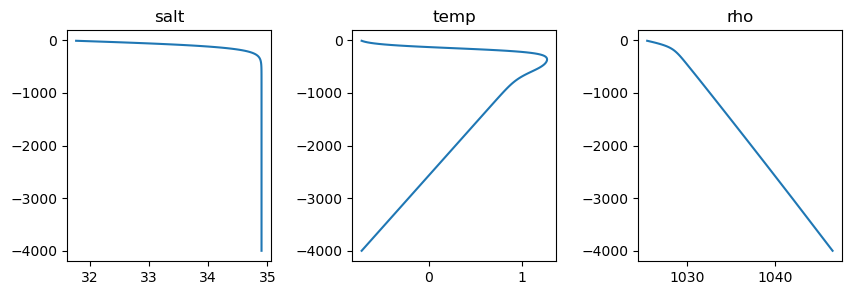

In [8]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(init_sal_s,-z_faces)
ax[0].set_title('salt')
ax[1].plot(init_temp_s,-z_faces)
ax[1].set_title('temp')
ax[2].plot(init_rho_s,-z_faces)
ax[2].set_title('rho')
plt.subplots_adjust(wspace=0.4)
plt.show()

# Vortex initialization

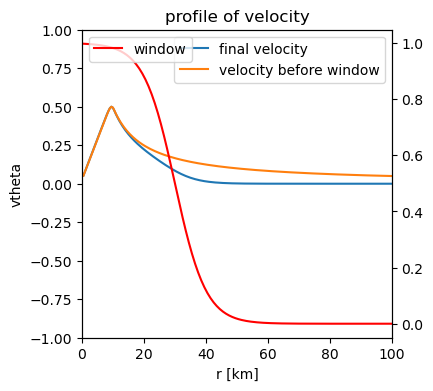

In [9]:
omega0_eddy          = V0_eddy / R_eddy 
u_eddy               = np.zeros( ( ngrid_z , ngrid_y + 1 , ngrid_x + 1 ) )#M_rho=ngrid_y
v_eddy               = np.zeros( ( ngrid_z , ngrid_y + 1, ngrid_x + 1 ) )
r                       = ( (xx-posx_eddy)**2 + (yy-posy_eddy)**2 )**0.5
theta                   = np.arctan2( (yy-posy_eddy) , (xx-posx_eddy) )
dr=0.5e3
r_work               = np.arange( dr, Lx*1.5 , dr)
theta_work           = np.pi*np.arange( -2. , 2 , 0.05 )
r_work , theta_work  = np.meshgrid( r_work , theta_work )
dr_work              = np.zeros((np.shape(r_work)))
dr_work[:,1:]        = r_work[:,1:] - r_work[:,:-1]
dr_work[:,0]         = dr_work[:,1]
x_work               = r_work * np.cos( theta_work )
y_work               = r_work * np.sin( theta_work )
dx_work              = np.zeros((np.shape(r_work)))
dx_work[:,1:]        = x_work[:,1:] - x_work[:,:-1]
dx_work[:,0]         = dx_work[:,1]
dy_work              = np.zeros((np.shape(r_work)))
dy_work[:,1:]        = y_work[:,1:] - y_work[:,:-1]
dy_work[:,0]         = dy_work[:,1]
omega_work           = type_eddy*omega0_eddy * np.exp( -(r_work / R_eddy )**power_shape )
#vtheta_ana           = -omega0*0.5*R_eddy**2/r_work * ( np.exp( -(r_work/R_eddy)**2) - 1 )
vtheta_work          = np.zeros((np.shape(omega_work)))
vtheta_work          =  1 / r_work * np.cumsum( r_work * omega_work * dr_work , axis = 1 )



#vtheta_work=vtheta_work-vtheta_work[0,0] #to remove small prblm at the center
###be careful, the window can weaken the velocity and change the radomega_workius
#and also the intensity since the decay is large
vtheta_work_beforeWIN=np.copy(vtheta_work)
if window=='yes':
    WIN_R                = 0.5 * ( 1 - np.tanh( (r_work-(3*R_eddy))/R_eddy)) #the window to avoid velocities at edges ##
if window=='no':
    WIN_R = np.ones_like(r_work)
    
vtheta_work          *= WIN_R
vtheta_work=V0_eddy*vtheta_work/np.max(np.abs(vtheta_work)) # to have the correct value t the peak
vtheta_work_beforeWIN=V0_eddy*vtheta_work_beforeWIN/np.max(np.abs(vtheta_work_beforeWIN)) # to have the correct value t the peak



plt.figure(figsize=(4,4))
plt.title('profile of velocity')
ax=plt.subplot(111)
plt.plot(r_work[0]/1e3,vtheta_work[0],'-',label='final velocity')
plt.plot(r_work[0]/1e3,vtheta_work_beforeWIN[0],'-',label='velocity before window')
plt.legend()
plt.ylabel('vtheta')
plt.xlabel('r [km]')
plt.axis([0,100,-V0_eddy*2,V0_eddy*2])
ax2=ax.twinx()
plt.plot(r_work[0]/1e3,WIN_R[0],'-r',label='window')
plt.legend(loc=2)
plt.show()

In [10]:
zr=-np.tile(depth,(ngrid_y + 1, ngrid_x + 1, 1)).T ## Attention to minus and edge grid

(elem,coef)          = get_tri_coef( x_work , y_work , xx - posx_eddy , yy - posy_eddy )
VHtheta_eddy         = np.nansum( coef * (vtheta_work.ravel())[elem] , 2 )



Vtheta_eddy=np.zeros_like(zr)
for ilev in np.arange( 0 , ngrid_z , 1 ):
        Vtheta_eddy[ilev]                = VHtheta_eddy * Vvertical( zr[ilev,:,:] , posz_eddy , H_eddy )

        u_eddy[ilev,:,:]           = -Vtheta_eddy[ilev] * np.sin( theta )
        v_eddy[ilev,:,:]           = Vtheta_eddy[ilev] * np.cos( theta )

ilev=0
vort_tmp=np.gradient(v_eddy[ilev],axis=1)/dy-np.gradient(u_eddy[ilev],axis=0)/dx

#smooth to avoid lil peak at the center

u_eddy_smoothed=np.zeros(u_eddy.shape)
v_eddy_smoothed=np.zeros(v_eddy.shape)
ratio_sig_ok=5  #the ratio R/dx for which sigma=1, with R=50km and dx= 10km
sigma=(R_eddy/dx)/ratio_sig_ok
#sigma=10e3/resolution #this one is ok for all dx but just for r=50km



for ilev in np.arange( 0 , ngrid_z , 1 ):
    u_eddy_smoothed[ilev,:,:]=gaussian_filter(u_eddy[ilev,:,:],sigma)
    v_eddy_smoothed[ilev,:,:]=gaussian_filter(v_eddy[ilev,:,:],sigma)



ilev=0
vort_tmp=np.gradient(v_eddy[ilev],axis=1)/dx-np.gradient(u_eddy[ilev],axis=0)/dx




u_eddy=u_eddy_smoothed
v_eddy=v_eddy_smoothed



#make another lil correction to have the correct peak value
u_eddy=V0_eddy*u_eddy/np.nanmax(u_eddy)
v_eddy=V0_eddy*v_eddy/np.nanmax(v_eddy)



vort_tmp_final=np.gradient(v_eddy[ilev],axis=1)/dx-np.gradient(u_eddy[ilev],axis=0)/dx


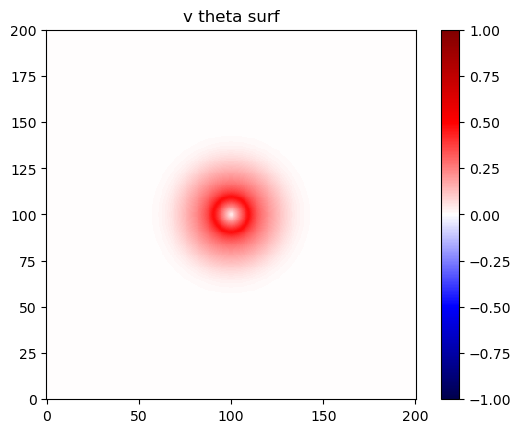

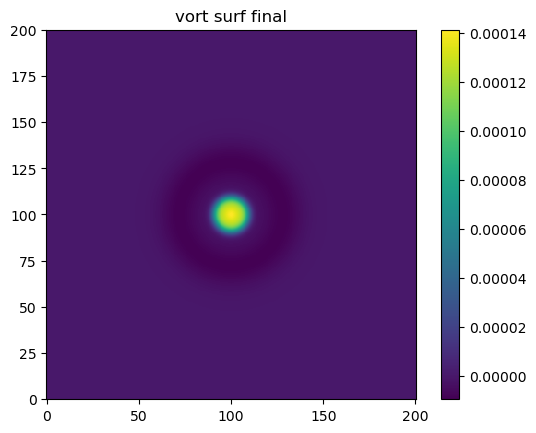

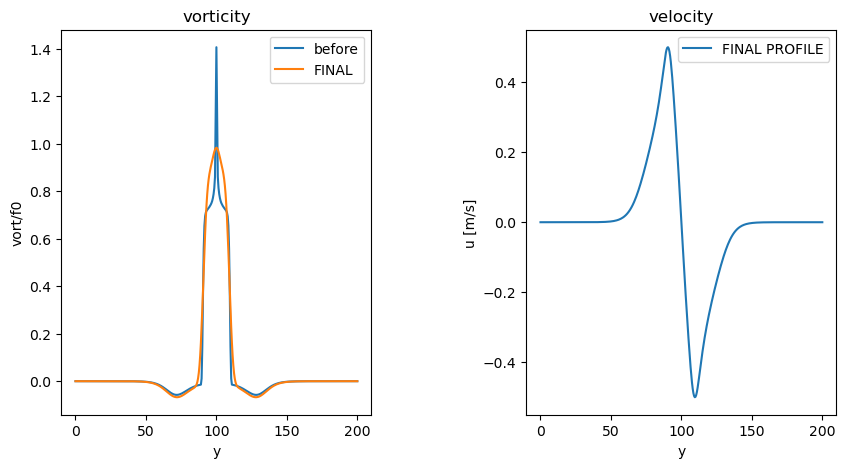

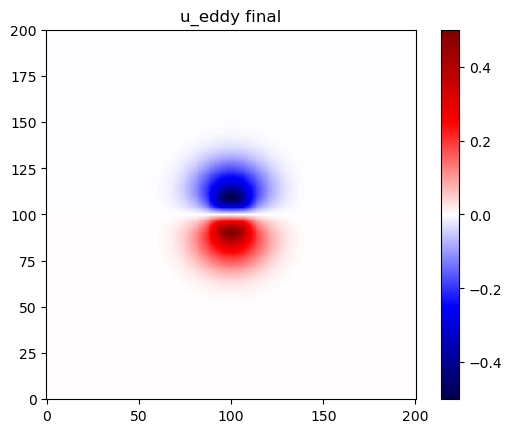

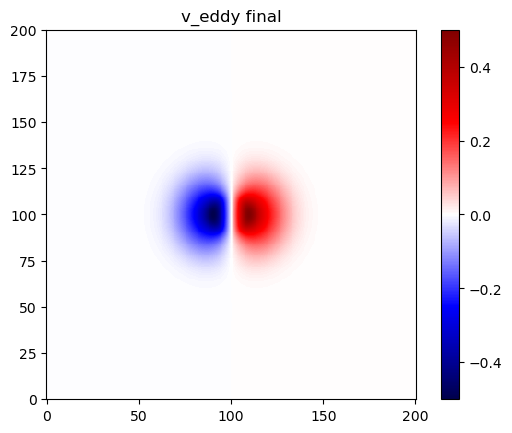

In [11]:
plt.figure()
plt.subplot(aspect='equal')
plt.title('v theta surf')
plt.pcolormesh((xx)/1e3,(yy)/1e3,Vtheta_eddy[0] ,vmin=-1,vmax=1,cmap='seismic')
plt.colorbar()
#plt.axis([-500,500,-500,500])
plt.show()

plt.figure()
plt.subplot(aspect='equal')
plt.title('vort surf final')
plt.pcolormesh((xx)/1e3,(yy)/1e3,vort_tmp_final)
plt.colorbar()
#plt.axis([-500,500,-500,500])
plt.show()


icut=int(len(xx)/2)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('vorticity')
plt.plot(yy[:,icut]/1e3,vort_tmp[:,icut]/f0,label='before')
plt.plot(yy[:,icut]/1e3,vort_tmp_final[:,icut]/f0,label='FINAL')
plt.ylabel('vort/f0')
plt.xlabel('y')
plt.legend()
plt.subplot(122)
plt.title('velocity')
plt.plot(yy[:,icut]/1e3,u_eddy[ilev,:,icut],label='FINAL PROFILE')
plt.ylabel('u [m/s]')
plt.xlabel('y')
plt.legend()
plt.subplots_adjust(wspace=0.5)

plt.show()



plt.figure()
plt.subplot(aspect='equal')
plt.title('u_eddy final')
plt.pcolormesh((xx)/1e3,(yy)/1e3,u_eddy[0],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.colorbar()
#plt.axis([-500,500,-500,500])
plt.show()

plt.figure()
plt.subplot(aspect='equal')
plt.title('v_eddy final')
plt.pcolormesh((xx)/1e3,(yy)/1e3,v_eddy[0],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.colorbar()
#plt.axis([-500,500,-500,500])
plt.show()

# now that we have the velocity field, compute the T,S fields

In [12]:
dudx=np.gradient(u_eddy,axis=2)/dx
dudy=np.gradient(u_eddy,axis=1)/dy
dvdx=np.gradient(v_eddy,axis=2)/dx
dvdy=np.gradient(v_eddy,axis=1)/dy


alpha0               = 1
alpha1               = 1
betaT                = 2.8e-4
betaS                = 8e-4
g=9.81
fcor_3d              = f0*np.ones_like(zr)
################# COMPUTE PRESSURE EDDY FIELD #################@
LHS     = init_rho_s[:,None,None]*( 2. * ( dudx*dvdy - dvdx*dudy ) + fcor_3d * ( dvdx - dudy ) )




pm                = np.ones( ( np.shape(xx) ) ) / dx
pn                = np.ones( ( np.shape(xx) ) ) / dy
A           = poisson_matrix_fast(pm.T,pn.T)
P_eddy      = np.zeros((ngrid_z, ngrid_y + 1, ngrid_x + 1))
for ilev in np.arange( 0 , ngrid_z , 1 ):
    X                 = spsolve(A,(LHS[ilev,:,:].T).ravel())
    P_eddy[ilev,:,:]  = -np.transpose( np.reshape( X , (ngrid_y + 1,ngrid_x + 1) ) , (1,0) )

################# COMPUTE SSH FIELD ###################################@

eta_eddy             = P_eddy[0,:,:] / (rho0*g)

###################### COMPUTE DENSITY EDDY FIELD (HYDROSTATIC BALANCE) ###################

dens_eddy            = -(1/g) * np.gradient(P_eddy,axis=0)/np.gradient(zr,axis=0)

################### COMPUTE TEMPERATURE/SALINITY EDDY FIELD (eq of state) #########################

## here if we want temp eddy
# temp_eddy            = -dens_eddy / (rho0*betaT)
# salt_eddy            = np.zeros((np.shape(temp_eddy))) 

## here if we want salt eddy
# temp_eddy            = np.zeros_like(zr) 
temp_eddy            = -dens_eddy / (rho0*betaT)
salt_eddy            = dens_eddy / (rho0*betaS)

In [13]:
# if type_eddy == 1:
#     temp_tot=(temp_eddy - np.min(temp_eddy))+init_temp_s[:,None,None]
# else:
#     temp_tot=temp_eddy+init_temp_s[:,None,None]
    
temp_tot = np.ones_like(temp_eddy) * init_temp_s[:,None,None]

salt_tot=salt_eddy+init_sal_s[:,None,None]
rho_tot=dens_eddy+init_rho_s[:,None,None]

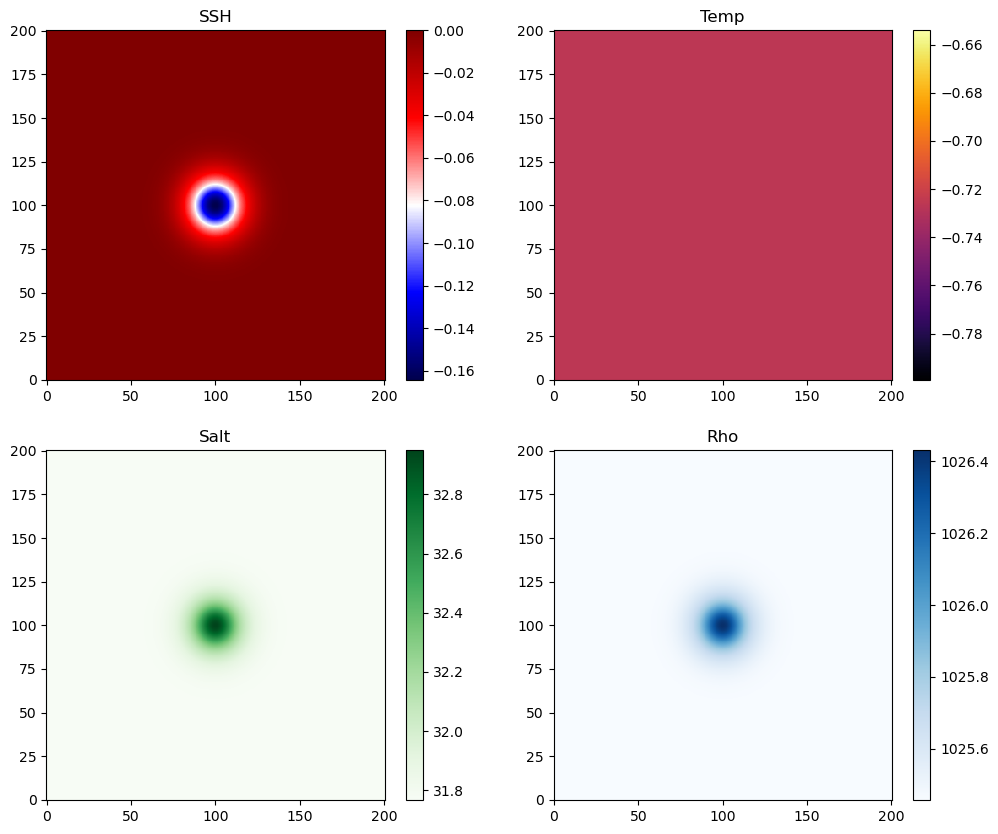

In [14]:
plt.figure(figsize=(12,10))

ax=plt.subplot(221)
plt.title('SSH')
# plt.subplot(aspect='equal')
plt.pcolormesh((xx)/1e3,(yy)/1e3,eta_eddy,cmap='seismic')
plt.colorbar()

ax=plt.subplot(222)
plt.title('Temp')
# plt.subplot(aspect='equal')
plt.pcolormesh((xx)/1e3,(yy)/1e3,temp_tot[0,:,:],cmap='inferno')
plt.colorbar()

ax=plt.subplot(223)
plt.title('Salt')
# plt.subplot(aspect='equal')
plt.pcolormesh((xx)/1e3,(yy)/1e3,salt_tot[0,:,:],cmap='Greens')
plt.colorbar()

ax=plt.subplot(224)
plt.title('Rho')
# plt.subplot(aspect='equal')
plt.pcolormesh((xx)/1e3,(yy)/1e3,rho_tot[0,:,:],cmap='Blues')
plt.colorbar()


Text(0.5, 0, 'X-direction [km]')

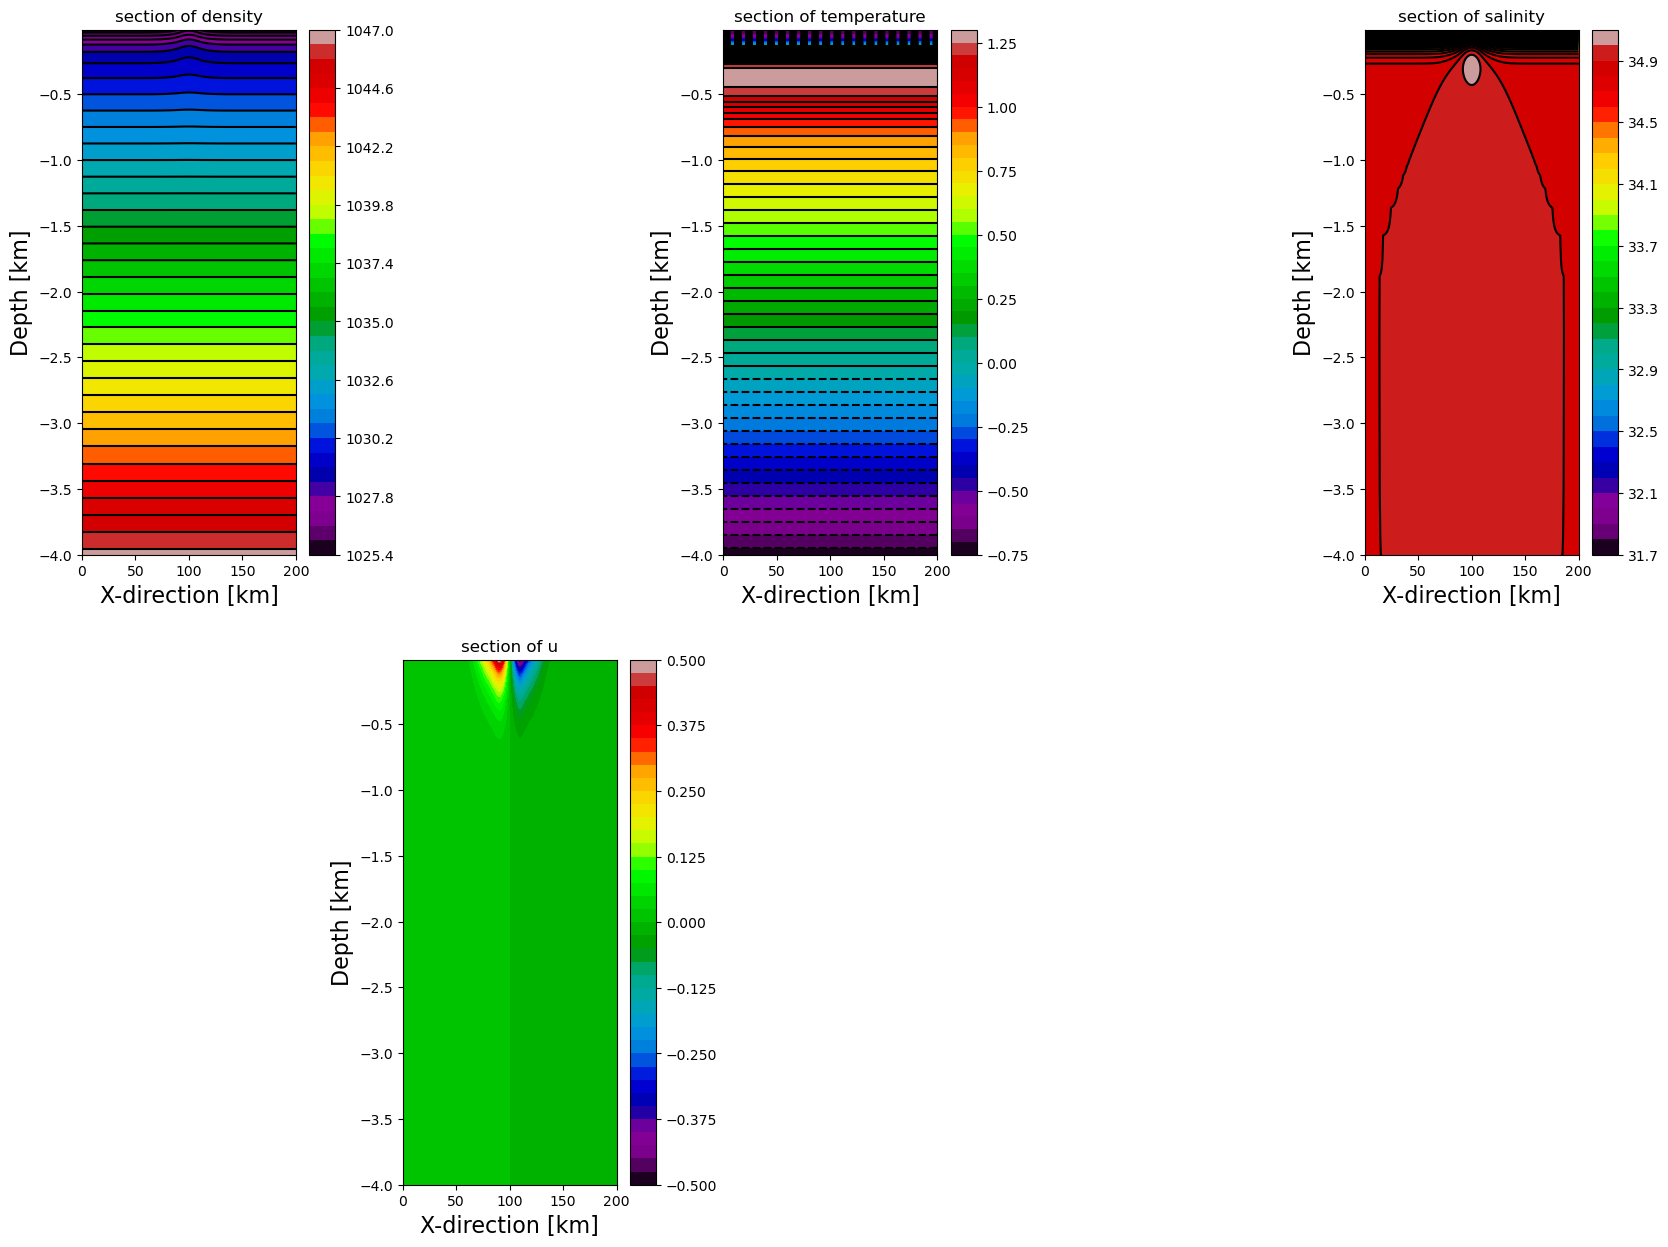

In [15]:
#sections across the eddy

icut=int(ngrid_x/2)
plt.figure(figsize=(20,15))

ax=plt.subplot(253)
plt.title('section of temperature')
plt.contourf(np.tile(yy[:,icut],(ngrid_z,1))/1000,zr[:,:,icut]/1000,temp_tot[:,:,icut],40,cmap='nipy_spectral')
plt.colorbar()
plt.contour(np.tile(yy[:,icut],(ngrid_z,1))/1000,zr[:,:,icut]/1000,temp_tot[:,:,icut],40,colors='k')#,cmap='nipy_spectral')
plt.ylabel('Depth [km]',fontsize=16)
plt.xlabel('X-direction [km]',fontsize=16)
#ax.set_ylim(-1,0)


ax=plt.subplot(255)
plt.title('section of salinity')
plt.contourf(np.tile(yy[:,icut],(ngrid_z,1))/1000,zr[:,:,icut]/1000,salt_tot[:,:,icut],40,cmap='nipy_spectral')
plt.colorbar()
plt.contour(np.tile(yy[:,icut],(ngrid_z,1))/1000,zr[:,:,icut]/1000,salt_tot[:,:,icut],40,colors='k')#,cmap='nipy_spectral')
plt.ylabel('Depth [km]',fontsize=16)
plt.xlabel('X-direction [km]',fontsize=16)
#ax.set_ylim(-1,0)

#sections across the eddy


ax=plt.subplot(251)
plt.title('section of density')
plt.contourf(np.tile(yy[:,icut],(ngrid_z,1))/1000,zr[:,:,icut]/1000,rho_tot[:,:,icut],40,cmap='nipy_spectral')
plt.colorbar()
plt.contour(np.tile(yy[:,icut],(ngrid_z,1))/1000,zr[:,:,icut]/1000,rho_tot[:,:,icut],40,colors='k')#,cmap='nipy_spectral')
plt.ylabel('Depth [km]',fontsize=16)
plt.xlabel('X-direction [km]',fontsize=16)
#ax.set_ylim(-1,0)


ax=plt.subplot(257)
plt.title('section of u')
plt.contourf(np.tile(yy[:,icut],(ngrid_z,1))/1000,zr[:,:,icut]/1000,u_eddy[:,:,icut],40,cmap='nipy_spectral')
plt.colorbar()
#plt.contour(np.tile(yy[:,icut],(ngrid_z,1))/1000,zr[:,:,icut]/1000,u_eddy[:,:,icut],40,colors='k')#,cmap='nipy_spectral')
plt.ylabel('Depth [km]',fontsize=16)
plt.xlabel('X-direction [km]',fontsize=16)


In [16]:
# fix_u_julia = np.zeros( ( ngrid_z , ngrid_y , ngrid_x + 1 ) )
# fix_u_julia[:,:,:-1] = u_eddy 

# fix_v_julia = np.zeros( ( ngrid_z , ngrid_y +1 , ngrid_x  ) )
# fix_v_julia[:,:-1,:] = v_eddy 

# Set properly the tracers in the julia coordinates. 
The initial conditions were originated using the edge coordinates of the simulation.

In [17]:
def interp_axis1(field):
    field_interp_X = ((field + np.roll(field,1,axis=1))/2)[:,:-1,:]
    return field_interp_X

def interp_axis2(field):
    field_interp_Y = ((field + np.roll(field,1,axis=2))/2)[:,:,:-1]
    return field_interp_Y

def interp_field_3d(field):
    # Interp X
    field = interp_axis1(field)
    # Interp Y
    field = interp_axis2(field)
    
    return field
    
def interp_field_2d(field):
    # interp X
    field_interp_X = ((field + np.roll(field,1,axis=0))/2)[:-1,:]
    field_interp_Y = ((field_interp_X + np.roll(field_interp_X,1,axis=1))/2)[:,:-1]
    
    return field_interp_Y
    

In [18]:
interp_temp = interp_field_3d(temp_tot)
interp_salt = interp_field_3d(salt_tot)
interp_rho = interp_field_3d(rho_tot)

interp_eta = interp_field_2d(eta_eddy)

u_interp = interp_axis1(u_eddy)
v_interp = interp_axis2(v_eddy)

In [19]:
print(u_interp.shape)
print(v_interp.shape)
print(interp_temp.shape)

(100, 400, 401)
(100, 401, 400)
(100, 400, 400)


In [20]:
dsout = xr.Dataset(coords=dict(x=(["x"], x), xu=(["xu"], xu), y=(["y"], y),yv=(["yv"], yv),z=(['z'],depth)))

dsout['votemper'] = (('z','y','x'),interp_temp)
dsout['vosaline'] = (('z','y','x'),interp_salt)
dsout['vorho']    = (('z','y','x'),interp_rho)
dsout['uoce']    = (('z','y','xu'),u_interp)
dsout['voce']    = (('z','yv','x'),v_interp)
dsout['ssh']    = (('y','x'),interp_eta)


In [21]:
dsout.to_netcdf(path_save+'init_julia.nc')

In [22]:
path_save

'/data/hpcflash/users/josnez/Oceananigans/ICE-EDDY_wJ/V0/init_cond/C-0/'

--> this is the location of your initial condition